# BIoMétrie : Generative Adversarial Networks


L’objectif de ce TP est d’implémenter une architecture neuronale complexe, comme les réseaux génératifs antagonistes, pour apprendre à générer des images. Le TP est aussi l’occasion d’appréhender en TF l’apprentissage de réseaux complexes avec des fonctions de pertes qui n’affectent qu’une partie des poids du réseau seulement. Nous utiliserons la base de chiffres MNIST
accessibles depuis le module dataset de Keras.

### Installer

In [124]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
tf.__version__

'2.10.0'

In [3]:
import numpy as np
import tensorflow.keras.datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
import time
import os
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('seaborn')

C:\Users\Brani\AppData\Local\Temp\ipykernel_83628\3514171520.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Charger et préparer le jeu de données
Nous utiliserons le jeu de données `MNIST` pour former le générateur et le discriminateur. Le générateur générera des chiffres manuscrits ressemblant aux données MNIST.

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

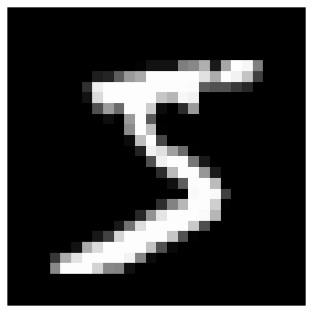

In [5]:
plt.imshow(train_images[0], cmap='gray')
plt.axis(False)
plt.grid(False)

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [8]:
nb_images, rows, cols = train_images.shape

In [9]:
# Transformation sous forme tensor (nb_images, h,w, ch)
train_images = train_images.reshape(nb_images, rows, cols, 1).astype('float32')
# Normalisation des images
train_images = train_images / 255.0

In [10]:
BUFFER_SIZE = nb_images # 60000
BATCH_SIZE = 256
INPUT_SHAPE_GENERATOR = 32
INPUT_SHAPE_DISCRIMINATOR = (rows, cols)

In [11]:
# Batch ans shuffle the data
train_images = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_images = list(train_images.as_numpy_iterator())

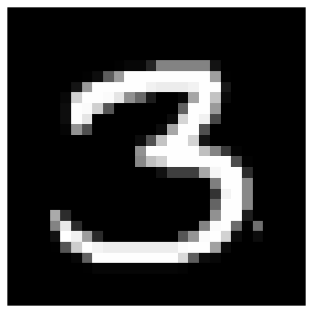

In [12]:
plt.imshow(train_images[0][0], cmap='gray')
plt.axis(False)
plt.grid(False)

### Instanciation de G et D
Le générateur et le discriminateur sont définis à l'aide de l' API séquentielle Keras.

##### Le générateur
Le générateur utilise `tf.keras.layers.Conv2DTranspose` (suréchantillonnage) pour produire une image à partir d'une graine (bruit aléatoire). Commencez avec une couche Dense qui prend cette graine en entrée, puis suréchantillonnez plusieurs fois jusqu'à ce que vous atteigniez la taille d'image souhaitée de 28x28x1. Notez l'activation de `tf.keras.layers.LeakyReLU` pour chaque couche, à l'exception de la couche de sortie qui utilise `tanh`.

##### 1. Créer un générateur G avec une architecture

In [13]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(14*14*128, use_bias=False, input_shape=(INPUT_SHAPE_GENERATOR,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((14, 14, 128)))
    assert model.output_shape == (None, 14, 14, 128)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 28, 28, 1)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    return model

Utilisez le générateur (pas encore formé) pour créer une image.


In [14]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25088)             802816    
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 25088)             0         
                                                                 
 reshape (Reshape)           (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 256)      819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 256)      1

In [15]:
plot_model(generator, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


(-0.5, 27.5, 27.5, -0.5)

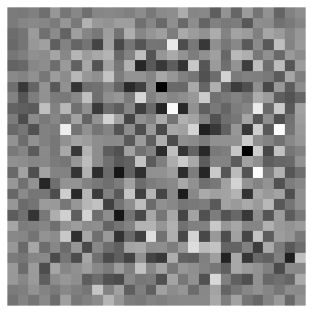

In [16]:
noise = tf.random.normal([1, INPUT_SHAPE_GENERATOR])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.grid(False); plt.axis(False)

#### Le discriminateur


##### 2. Créer un discriminateur D avec une architecture CNN.

In [17]:
def make_discriminator_model():
    model=tf.keras.Sequential()

    model.add(layers.Conv2D(64, (5, 5), strides=(1, 1), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation=tf.nn.relu))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

Utilisez le discriminateur (pas encore formé) pour classer les images générées comme réelles ou fausses. Le modèle sera formé pour générer des valeurs positives pour les images réelles et des valeurs négatives pour les images factices.

In [18]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 batch_normalization_5 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 28, 28, 128)       0         
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                      

In [19]:
plot_model(discriminator, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49705392]], shape=(1, 1), dtype=float32)


#### Création du GAN

Maintenant que nous avons instancié les deux modules élémentaires `generator` et `decriminator`, nous allons pouvoir créer le réseau GAN utilisé pour l’apprentissage antagoniste.

#### Define the loss and optimizers
Define loss functions and optimizers for both models.

##### 3. Pour la partie du discriminateur D, simplement compiler le module D avec la loss binary_crossentropy et l’optimiseur Adam. Utiliser la fonction summary pour visualiser l’architecture de votre réseau D.


In [21]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) # car sigmoid

In [22]:
discriminator.compile(optimizer='Adam', loss=cross_entropy, metrics=['accuracy'])

In [23]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 batch_normalization_5 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       204928    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 28, 28, 128)       0         
                                                                 
 batch_normalization_6 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                      

##### 4. Pour la partie du générateur G, l’apprentissage consiste à optimiser les poids du générateur G pour un état donné du discriminateur D

— Faire une recopie du discriminateur D pour créer le discriminateur
discriminateur_gan.  
— Déclarer les poids de ce discriminateur comme non-entrainables, en fixant la valeur de son attribut trainable à False.  
— Instancier le réseau GAN, avec comme entrée la taille du code latent aléatoire et comme sortie la composition de discriminator_gan(generator(gan_input)).  
— Définir la loss binary_crossentropy et l’optimiseur Adam.  

In [24]:
from tensorflow.keras.models import clone_model
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, concatenate
import numpy as np

discriminator_gan = clone_model(discriminator)
discriminator_gan.trainable = False

In [25]:
gan_input = tf.keras.layers.Input([INPUT_SHAPE_GENERATOR,])
GAN = discriminator_gan(generator(gan_input))
GAN = Model(gan_input, GAN)
GAN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         2749764   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 29739777  
                                                                 
Total params: 32,489,541
Trainable params: 2,698,690
Non-trainable params: 29,790,851
_________________________________________________________________


In [26]:
tf.keras.utils.plot_model(GAN, to_file= 'GAN.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
GAN.compile(optimizer='Adam', loss=cross_entropy, metrics=['accuracy'])

In [28]:
plot_model(GAN, show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


#### Apprentissage du GAN

Nous allons maintenant procédé à l’apprentissage alterné des poids du générateur G et du discriminateur. Pour ce faire, nous allons créer notre propre boucle pour traiter les batches. Nous reproduirons pour chaque batches les étapes suivantes :  

5. Réaliser un tirage aléatoire du code latent, en utilisant un tirage aléatoire dans une distribution normale. Pour ce faire on utilisera la fonction `random de numpy` ou `random de tensorflow`.  
6. Réaliser la prédiction des images générées à partir de `G` et du code latent.  
7. Construire un mélange d’images réelles tirées aléatoirement et d’images générées avec les labels correspondant.  
8. Entrainer le discriminateur `D` à partir de ce mélange. On utilisera la méthode `train_on_batch`.  
9. Réaliser un nouveau tirage aléatoire du code latent, et créer les labels correspondants à "réel".  
10. Entrainer le réseau antagoniste à partir de ces données. On utilisera la méthode `train_on_batch`.  
Nous ferons un affichage des losses du discriminateur D et réseau antagoniste GAN toutes les 10 époques, et un tracé de 10 images produites par le générateur.  

In [116]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
# @tf.function
def train_step(real_images, gan, generator):
  noise = np.random.normal(loc=0.0, scale=1.0, size=(BATCH_SIZE, INPUT_SHAPE_GENERATOR))
  generated_images = generator(noise, training=True)
  combined_images = np.concatenate([generated_images.numpy(), real_images])
  labels = np.concatenate([np.zeros((BATCH_SIZE, 1)),
                           np.ones((BATCH_SIZE, 1))])
  labels += 0.05 * np.random.random(labels.shape) # astuce trover sur internet 
  d_loss, d_acc = discriminator.train_on_batch(combined_images, labels)
  noise = np.random.normal(loc=0.0, scale=1.0, size=(BATCH_SIZE, INPUT_SHAPE_GENERATOR))
  misleading_labels = np.ones((BATCH_SIZE, 1))
  gan_loss, gan_acc = gan.train_on_batch(noise, misleading_labels)

  return d_loss, d_acc, gan_loss, gan_acc

#### Générer et enregistrer des images

In [117]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

#### Générer et enregistrer des images

In [118]:

def train(dataset, gan, generator, epochs=50):
  history = { 'd_loss'   : [],
              'd_acc'   : [],
              'gan_loss' : [],
              'gan_acc'  : [] }
  
  checkpoint_dir = './training_checkpoints'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(generator_optimizer=tf.keras.optimizers.Adam(),
                                   gan_optimizer=tf.keras.optimizers.Adam(), 
                                   generator=generator,
                                   gan=gan) 
  
  seed = tf.random.normal([BATCH_SIZE, INPUT_SHAPE_GENERATOR])
  
  for epoch in range(epochs):
    print(f'epoch {epoch+1}')
    start = time.time()

    for image_batch in dataset:
      d_loss, d_acc, gan_loss, gan_acc  = train_step(image_batch, gan, generator)
      history['d_loss'].append(d_loss), history['d_acc'].append(d_acc)
      history['gan_loss'].append(gan_loss), history['gan_acc'].append(gan_acc)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

  # generator.save('models/generator.h5')  # creates a HDF5 file 'my_model.h5'
  return generator, gan, history


In [122]:
# tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [115]:
generator, gan, history = train(train_images, GAN, generator, epochs=5)

bra
bra
bra
branis
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
bra
bra
bra
bra
bra
bra


KeyError: 'd_acc'

In [123]:
history.plot()

NameError: name 'history' is not defined